## Import

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
import lightgbm as lgb
import gc
from sklearn.utils import shuffle
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error

import math
import matplotlib.pyplot as plt
import seaborn as sns

import datetime as dt
import missingno as msno

from collections import Counter
from matplotlib import rc

In [ ]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree       
Reading state information... Done
fonts-nanum is already the newest version (20170925-1).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 4 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 10 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/var/cache/fontconfig: cleaning cache directory
/root/.cache/fontconfig: not cleaning non-existent 

## csv to parquet

In [ ]:
def csv_to_parquet(csv_path, save_name):
    df = pd.read_csv(csv_path)
    df.to_parquet(f'./{save_name}.parquet')
    del df
    gc.collect()
    print(save_name, 'Done.')

In [ ]:
csv_to_parquet('/content/drive/MyDrive/dacon/data/train.csv', 'train')
#csv_to_parquet('/content/drive/MyDrive/dacon/data/test.csv', 'test')

train Done.


## 데이터 불러오기

id = 아이디

base_date = 날짜

day_of_week = 요일

base_hour = 시간대

road_in_use = 도로사용여부

lane_count = 차로수

road_rating = 도로등급

multi_linked = 중용구간 여부

connect_code = 연결로 코드

maximum_speed_limit = 최고속도제한

weight_restricted = 통과제한하중

height_restricted = 통과제한높이

road_type = 도로유형

start_latitude = 시작지점의 위도

start_longtitude = 시작지점의 경도

start_tum_restricted = 시작지점의 회전제한

end_latitude = 도착지점의 위도

end_longtitude = 도착지점의 경도

end_tum_restricted = 도착지점의 회전제한

road_name = 도로명

start_node_name = 시작지점명

end_node_name = 도착지점명

vehicle_restricted = 통과제한차량

target = 평균속도(km)

In [ ]:
train = pd.read_parquet('./train.parquet')
#test = pd.read_parquet('./test.parquet')

In [ ]:
train.shape

(4701217, 23)

In [ ]:
train_df = train.copy()

In [ ]:
train['month']=train['base_date']
train

,id,base_date,day_of_week,base_hour,lane_count,road_rating,road_name,multi_linked,connect_code,maximum_speed_limit,...,start_node_name,start_latitude,start_longitude,start_turn_restricted,end_node_name,end_latitude,end_longitude,end_turn_restricted,target,month
0,TRAIN_0000000,20220623,목,17,1,106,지방도1112호선,0,0,60.0,...,제3교래교,33.427747,126.662612,없음,제3교래교,33.427749,126.662335,없음,52.0,20220623
1,TRAIN_0000001,20220728,목,21,2,103,일반국도11호선,0,0,60.0,...,광양사거리,33.500730,126.529107,있음,KAL사거리,33.504811,126.526240,없음,30.0,20220728
2,TRAIN_0000002,20211010,일,7,2,103,일반국도16호선,0,0,80.0,...,창고천교,33.279145,126.368598,없음,상창육교,33.280072,126.362147,없음,61.0,20211010
3,TRAIN_0000003,20220311,금,13,2,107,태평로,0,0,50.0,...,남양리조트,33.246081,126.567204,없음,서현주택,33.245565,126.566228,없음,20.0,20220311
4,TRAIN_0000004,20211005,화,8,2,103,일반국도12호선,0,0,80.0,...,애월샷시,33.462214,126.326551,없음,애월입구,33.462677,126.330152,없음,38.0,20211005
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4701212,TRAIN_4701212,20211104,목,16,1,107,-,0,0,50.0,...,대림사거리,33.422145,126.278125,없음,금덕해운,33.420955,126.273750,없음,20.0,20211104
4701213,TRAIN_4701213,20220331,목,2,2,107,-,0,0,80.0,...,광삼교,33.472505,126.424368,없음,광삼교,33.472525,126.424890,없음,65.0,20220331
4701214,TRAIN_4701214,20220613,월,22,2,103,일반국도12호선,0,0,60.0,...,고성교차로,33.447183,126.912579,없음,성산교차로,33.444121,126.912948,없음,30.0,20220613
4701215,TRAIN_4701215,20211020,수,2,2,103,일반국도95호선,0,0,80.0,...,제6광령교,33.443596,126.431817,없음,관광대학입구,33.444996,126.433332,없음,73.0,20211020


# column 추가

## 월(month)추가

In [ ]:
#train데이터에 추가
train['month'] = train['month'].apply(lambda x: pd.to_datetime(str(x), format='%Y-%m-%d'))

In [ ]:
train['month'] = train['month'].dt.month

In [ ]:
train=train.sort_values('base_date')

In [ ]:
train

,id,base_date,day_of_week,base_hour,lane_count,road_rating,road_name,multi_linked,connect_code,maximum_speed_limit,...,start_node_name,start_latitude,start_longitude,start_turn_restricted,end_node_name,end_latitude,end_longitude,end_turn_restricted,target,month
430379,TRAIN_0430379,20210901,수,16,3,106,지방도1132호선,0,0,70.0,...,진동1로,33.518987,126.568861,있음,동중입구,33.519726,126.571488,없음,37.0,9
369019,TRAIN_0369019,20210901,수,11,1,103,일반국도16호선,0,0,50.0,...,모살물교,33.312509,126.703863,없음,한남교,33.312449,126.696173,없음,36.0,9
1132647,TRAIN_1132647,20210901,수,4,2,103,일반국도12호선,0,0,80.0,...,애월샷시,33.462214,126.326551,없음,애월입구,33.462677,126.330152,없음,43.0,9
4543127,TRAIN_4543127,20210901,수,16,1,107,-,0,0,60.0,...,서중2교,33.331742,126.676431,없음,한남교차로,33.325096,126.665698,없음,55.0,9
3428956,TRAIN_3428956,20210901,수,9,1,103,일반국도16호선,0,0,50.0,...,월산2교,33.260056,126.490987,없음,월산2교,33.259995,126.491306,없음,53.0,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2053638,TRAIN_2053638,20220731,일,21,1,107,중문로,0,0,50.0,...,신양약방,33.251716,126.425612,없음,중문한의원,33.251884,126.423200,없음,21.0,7
2748124,TRAIN_2748124,20220731,일,12,3,107,연삼로,0,0,70.0,...,제2거로교,33.508464,126.558231,없음,거로사거리,33.507349,126.556173,있음,36.0,7
2447938,TRAIN_2447938,20220731,일,12,2,107,경찰로,0,0,60.0,...,신성교회,33.253074,126.506393,없음,서호2차현대맨션203동,33.252183,126.506069,없음,24.0,7
3749761,TRAIN_3749761,20220731,일,1,2,103,일반국도16호선,0,0,60.0,...,서홍교,33.264112,126.554043,없음,서흥동사무소,33.263685,126.550978,없음,37.0,7


## weekend 추가 (평일 0, 주말 1 나누기)

In [ ]:
workday = ['월', '화', '수', '목', '금']
playday = ['토', '일']

weekend=[]

for row in train['day_of_week']:
    if row in workday:
        weekend.append(0)   # 평일 0
    elif row in playday:
        weekend.append(1)   # 주말 1

train['weekend'] = weekend

In [ ]:
train

,id,base_date,day_of_week,base_hour,lane_count,road_rating,road_name,multi_linked,connect_code,maximum_speed_limit,...,start_latitude,start_longitude,start_turn_restricted,end_node_name,end_latitude,end_longitude,end_turn_restricted,target,month,weekend
430379,TRAIN_0430379,20210901,수,16,3,106,지방도1132호선,0,0,70.0,...,33.518987,126.568861,있음,동중입구,33.519726,126.571488,없음,37.0,9,0
369019,TRAIN_0369019,20210901,수,11,1,103,일반국도16호선,0,0,50.0,...,33.312509,126.703863,없음,한남교,33.312449,126.696173,없음,36.0,9,0
1132647,TRAIN_1132647,20210901,수,4,2,103,일반국도12호선,0,0,80.0,...,33.462214,126.326551,없음,애월입구,33.462677,126.330152,없음,43.0,9,0
4543127,TRAIN_4543127,20210901,수,16,1,107,-,0,0,60.0,...,33.331742,126.676431,없음,한남교차로,33.325096,126.665698,없음,55.0,9,0
3428956,TRAIN_3428956,20210901,수,9,1,103,일반국도16호선,0,0,50.0,...,33.260056,126.490987,없음,월산2교,33.259995,126.491306,없음,53.0,9,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2053638,TRAIN_2053638,20220731,일,21,1,107,중문로,0,0,50.0,...,33.251716,126.425612,없음,중문한의원,33.251884,126.423200,없음,21.0,7,1
2748124,TRAIN_2748124,20220731,일,12,3,107,연삼로,0,0,70.0,...,33.508464,126.558231,없음,거로사거리,33.507349,126.556173,있음,36.0,7,1
2447938,TRAIN_2447938,20220731,일,12,2,107,경찰로,0,0,60.0,...,33.253074,126.506393,없음,서호2차현대맨션203동,33.252183,126.506069,없음,24.0,7,1
3749761,TRAIN_3749761,20220731,일,1,2,103,일반국도16호선,0,0,60.0,...,33.264112,126.554043,없음,서흥동사무소,33.263685,126.550978,없음,37.0,7,1


In [ ]:
train[train.duplicated()]

,id,base_date,day_of_week,base_hour,lane_count,road_rating,road_name,multi_linked,connect_code,maximum_speed_limit,...,start_latitude,start_longitude,start_turn_restricted,end_node_name,end_latitude,end_longitude,end_turn_restricted,target,month,weekend


### 시간대(hour_label) 추가

In [ ]:
dawn = [0,1,2,3,4,5]
morning = [6,7,8,9,10,11]
daytime = [12,13,14,15,16,17]
night = [18,19,20,21,22,23]

hour_label = []

for row in train['base_hour']:
    if row in dawn:
        hour_label.append('새벽')   # 새벽 0
    elif row in morning:
        hour_label.append('오전')   # 오전 1
    elif row in daytime:
        hour_label.append('오후')   # 오후 2
    elif row in night:
        hour_label.append('저녁')   # 저녁 3

train['hour_label'] = hour_label
train

,id,base_date,day_of_week,base_hour,lane_count,road_rating,road_name,multi_linked,connect_code,maximum_speed_limit,...,start_longitude,start_turn_restricted,end_node_name,end_latitude,end_longitude,end_turn_restricted,target,month,weekend,hour_label
430379,TRAIN_0430379,20210901,수,16,3,106,지방도1132호선,0,0,70.0,...,126.568861,있음,동중입구,33.519726,126.571488,없음,37.0,9,0,오후
369019,TRAIN_0369019,20210901,수,11,1,103,일반국도16호선,0,0,50.0,...,126.703863,없음,한남교,33.312449,126.696173,없음,36.0,9,0,오전
1132647,TRAIN_1132647,20210901,수,4,2,103,일반국도12호선,0,0,80.0,...,126.326551,없음,애월입구,33.462677,126.330152,없음,43.0,9,0,새벽
4543127,TRAIN_4543127,20210901,수,16,1,107,-,0,0,60.0,...,126.676431,없음,한남교차로,33.325096,126.665698,없음,55.0,9,0,오후
3428956,TRAIN_3428956,20210901,수,9,1,103,일반국도16호선,0,0,50.0,...,126.490987,없음,월산2교,33.259995,126.491306,없음,53.0,9,0,오전
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2053638,TRAIN_2053638,20220731,일,21,1,107,중문로,0,0,50.0,...,126.425612,없음,중문한의원,33.251884,126.423200,없음,21.0,7,1,저녁
2748124,TRAIN_2748124,20220731,일,12,3,107,연삼로,0,0,70.0,...,126.558231,없음,거로사거리,33.507349,126.556173,있음,36.0,7,1,오후
2447938,TRAIN_2447938,20220731,일,12,2,107,경찰로,0,0,60.0,...,126.506393,없음,서호2차현대맨션203동,33.252183,126.506069,없음,24.0,7,1,오후
3749761,TRAIN_3749761,20220731,일,1,2,103,일반국도16호선,0,0,60.0,...,126.554043,없음,서흥동사무소,33.263685,126.550978,없음,37.0,7,1,새벽


## 공휴일(holiday) 추가

In [ ]:
holi = [20210920, 20210921, 20210922, 20211004, 20211011, 20211009, 20211003, 20211225,
        20220101, 20220131, 20220201, 20220202, 20220301, 20220309, 20220501, 20220505,
        20220508, 20220601, 20220606, 20220717]

holiday = []

for row in train['base_date']:
    if row in holi:
        holiday.append(1)   # 공휴일이면 1
    else:
        holiday.append(0)   # 공휴일 아니면 0

train['holiday'] = holiday
train

,id,base_date,day_of_week,base_hour,lane_count,road_rating,road_name,multi_linked,connect_code,maximum_speed_limit,...,start_turn_restricted,end_node_name,end_latitude,end_longitude,end_turn_restricted,target,month,weekend,hour_label,holiday
430379,TRAIN_0430379,20210901,수,16,3,106,지방도1132호선,0,0,70.0,...,있음,동중입구,33.519726,126.571488,없음,37.0,9,0,오후,0
369019,TRAIN_0369019,20210901,수,11,1,103,일반국도16호선,0,0,50.0,...,없음,한남교,33.312449,126.696173,없음,36.0,9,0,오전,0
1132647,TRAIN_1132647,20210901,수,4,2,103,일반국도12호선,0,0,80.0,...,없음,애월입구,33.462677,126.330152,없음,43.0,9,0,새벽,0
4543127,TRAIN_4543127,20210901,수,16,1,107,-,0,0,60.0,...,없음,한남교차로,33.325096,126.665698,없음,55.0,9,0,오후,0
3428956,TRAIN_3428956,20210901,수,9,1,103,일반국도16호선,0,0,50.0,...,없음,월산2교,33.259995,126.491306,없음,53.0,9,0,오전,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2053638,TRAIN_2053638,20220731,일,21,1,107,중문로,0,0,50.0,...,없음,중문한의원,33.251884,126.423200,없음,21.0,7,1,저녁,0
2748124,TRAIN_2748124,20220731,일,12,3,107,연삼로,0,0,70.0,...,없음,거로사거리,33.507349,126.556173,있음,36.0,7,1,오후,0
2447938,TRAIN_2447938,20220731,일,12,2,107,경찰로,0,0,60.0,...,없음,서호2차현대맨션203동,33.252183,126.506069,없음,24.0,7,1,오후,0
3749761,TRAIN_3749761,20220731,일,1,2,103,일반국도16호선,0,0,60.0,...,없음,서흥동사무소,33.263685,126.550978,없음,37.0,7,1,새벽,0


## 장마(rain_season) 추가

In [ ]:
rainday = [20220621,20220622,20220623,20220624,20220625,20220626,20220627,20220628,20220629,20220630,
           20220701,20220702,20220703,20220704,20220705,20220706,20220707,20220708,20220709,20220710,
           20220711,20220712,20220713,20220714,20220715,20220716,20220717,20220718,20220719,20220720,
           20220721,20220722,20220723,20220724]

rain_season = []

for i in train['base_date']:
    if i in rainday:
        rain_season.append(1)
    else:
        rain_season.append(0)

train['rain_season'] = rain_season
train

,id,base_date,day_of_week,base_hour,lane_count,road_rating,road_name,multi_linked,connect_code,maximum_speed_limit,...,end_node_name,end_latitude,end_longitude,end_turn_restricted,target,month,weekend,hour_label,holiday,rain_season
430379,TRAIN_0430379,20210901,수,16,3,106,지방도1132호선,0,0,70.0,...,동중입구,33.519726,126.571488,없음,37.0,9,0,오후,0,0
369019,TRAIN_0369019,20210901,수,11,1,103,일반국도16호선,0,0,50.0,...,한남교,33.312449,126.696173,없음,36.0,9,0,오전,0,0
1132647,TRAIN_1132647,20210901,수,4,2,103,일반국도12호선,0,0,80.0,...,애월입구,33.462677,126.330152,없음,43.0,9,0,새벽,0,0
4543127,TRAIN_4543127,20210901,수,16,1,107,-,0,0,60.0,...,한남교차로,33.325096,126.665698,없음,55.0,9,0,오후,0,0
3428956,TRAIN_3428956,20210901,수,9,1,103,일반국도16호선,0,0,50.0,...,월산2교,33.259995,126.491306,없음,53.0,9,0,오전,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2053638,TRAIN_2053638,20220731,일,21,1,107,중문로,0,0,50.0,...,중문한의원,33.251884,126.423200,없음,21.0,7,1,저녁,0,0
2748124,TRAIN_2748124,20220731,일,12,3,107,연삼로,0,0,70.0,...,거로사거리,33.507349,126.556173,있음,36.0,7,1,오후,0,0
2447938,TRAIN_2447938,20220731,일,12,2,107,경찰로,0,0,60.0,...,서호2차현대맨션203동,33.252183,126.506069,없음,24.0,7,1,오후,0,0
3749761,TRAIN_3749761,20220731,일,1,2,103,일반국도16호선,0,0,60.0,...,서흥동사무소,33.263685,126.550978,없음,37.0,7,1,새벽,0,0


## 계절(season) 추가

In [ ]:
season = []

for i in train['month']: 
    if i in (3,4,5):     # 봄
        season.append('봄')
    elif i in (6,7,8):   # 여름
        season.append('여름')
    elif i in (9,10,11):  # 가을
        season.append('가을')
    elif i in (12,1,2):   # 겨울
        season.append('겨울')

train['season'] = season
train

,id,base_date,day_of_week,base_hour,lane_count,road_rating,road_name,multi_linked,connect_code,maximum_speed_limit,...,end_latitude,end_longitude,end_turn_restricted,target,month,weekend,hour_label,holiday,rain_season,season
430379,TRAIN_0430379,20210901,수,16,3,106,지방도1132호선,0,0,70.0,...,33.519726,126.571488,없음,37.0,9,0,오후,0,0,가을
369019,TRAIN_0369019,20210901,수,11,1,103,일반국도16호선,0,0,50.0,...,33.312449,126.696173,없음,36.0,9,0,오전,0,0,가을
1132647,TRAIN_1132647,20210901,수,4,2,103,일반국도12호선,0,0,80.0,...,33.462677,126.330152,없음,43.0,9,0,새벽,0,0,가을
4543127,TRAIN_4543127,20210901,수,16,1,107,-,0,0,60.0,...,33.325096,126.665698,없음,55.0,9,0,오후,0,0,가을
3428956,TRAIN_3428956,20210901,수,9,1,103,일반국도16호선,0,0,50.0,...,33.259995,126.491306,없음,53.0,9,0,오전,0,0,가을
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2053638,TRAIN_2053638,20220731,일,21,1,107,중문로,0,0,50.0,...,33.251884,126.423200,없음,21.0,7,1,저녁,0,0,여름
2748124,TRAIN_2748124,20220731,일,12,3,107,연삼로,0,0,70.0,...,33.507349,126.556173,있음,36.0,7,1,오후,0,0,여름
2447938,TRAIN_2447938,20220731,일,12,2,107,경찰로,0,0,60.0,...,33.252183,126.506069,없음,24.0,7,1,오후,0,0,여름
3749761,TRAIN_3749761,20220731,일,1,2,103,일반국도16호선,0,0,60.0,...,33.263685,126.550978,없음,37.0,7,1,새벽,0,0,여름


In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4701217 entries, 430379 to 4680098
Data columns (total 29 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   id                     object 
 1   base_date              int64  
 2   day_of_week            object 
 3   base_hour              int64  
 4   lane_count             int64  
 5   road_rating            int64  
 6   road_name              object 
 7   multi_linked           int64  
 8   connect_code           int64  
 9   maximum_speed_limit    float64
 10  vehicle_restricted     float64
 11  weight_restricted      float64
 12  height_restricted      float64
 13  road_type              int64  
 14  start_node_name        object 
 15  start_latitude         float64
 16  start_longitude        float64
 17  start_turn_restricted  object 
 18  end_node_name          object 
 19  end_latitude           float64
 20  end_longitude          float64
 21  end_turn_restricted    object 
 22  target       

# EDA

In [ ]:
import matplotlib.pyplot as plt

plt.rc('font', family='NanumBarunGothic') 

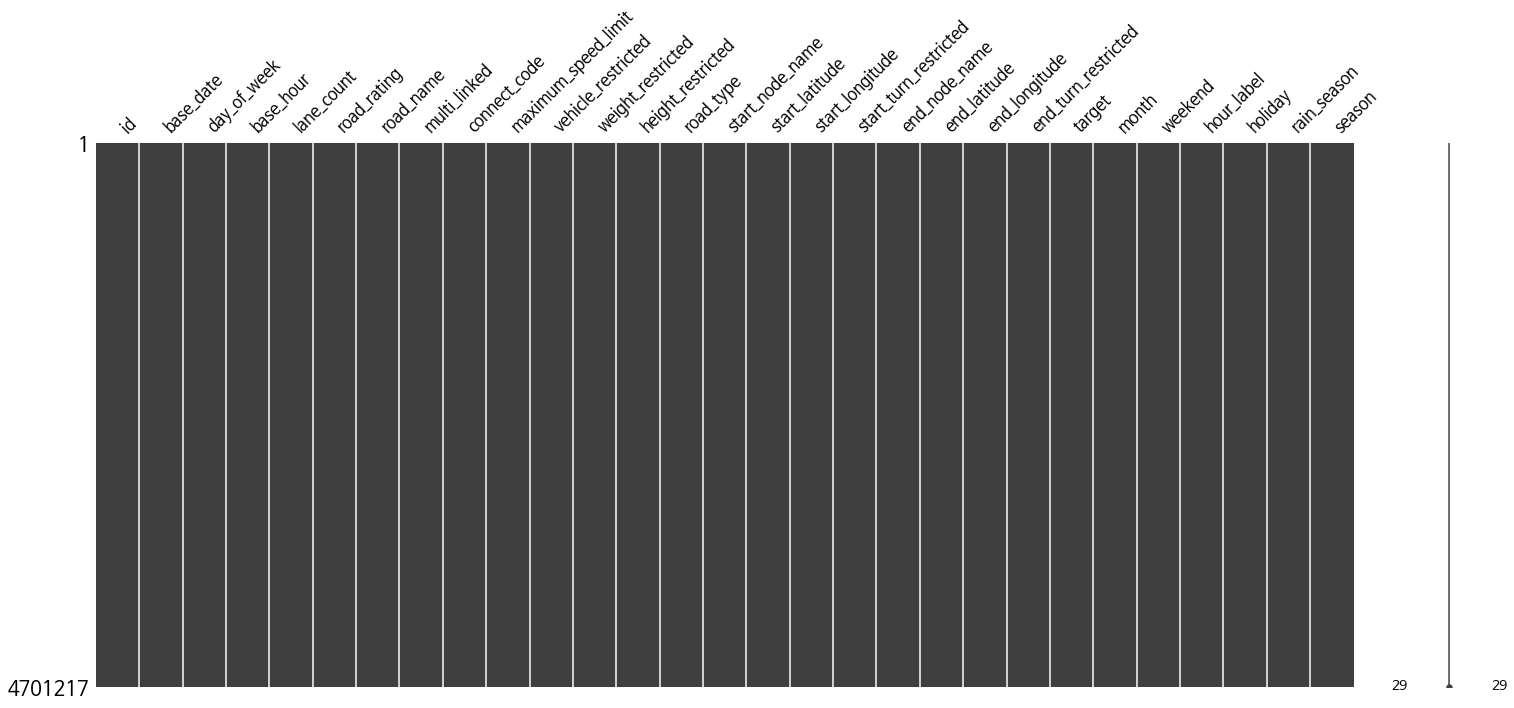

In [ ]:
# #train 결측치 확인
msno.matrix(train)

In [ ]:
train.isnull().sum()

id                       0
base_date                0
day_of_week              0
base_hour                0
lane_count               0
road_rating              0
road_name                0
multi_linked             0
connect_code             0
maximum_speed_limit      0
vehicle_restricted       0
weight_restricted        0
height_restricted        0
road_type                0
start_node_name          0
start_latitude           0
start_longitude          0
start_turn_restricted    0
end_node_name            0
end_latitude             0
end_longitude            0
end_turn_restricted      0
target                   0
month                    0
weekend                  0
hour_label               0
holiday                  0
rain_season              0
season                   0
dtype: int64

In [ ]:
# eda 함수

def show_plt(df, col):
  
    fig, ax = plt.subplots(ncols=2, figsize = (15,6))

    sns.kdeplot(data=df[col], ax=ax[0])
    sns.boxplot(data=df[col], ax=ax[1])

### 날짜 (base_date)

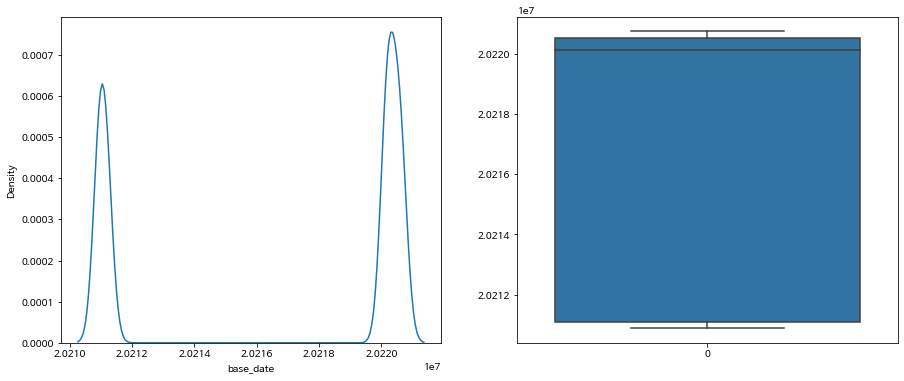

In [ ]:
show_plt(train, 'base_date')

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


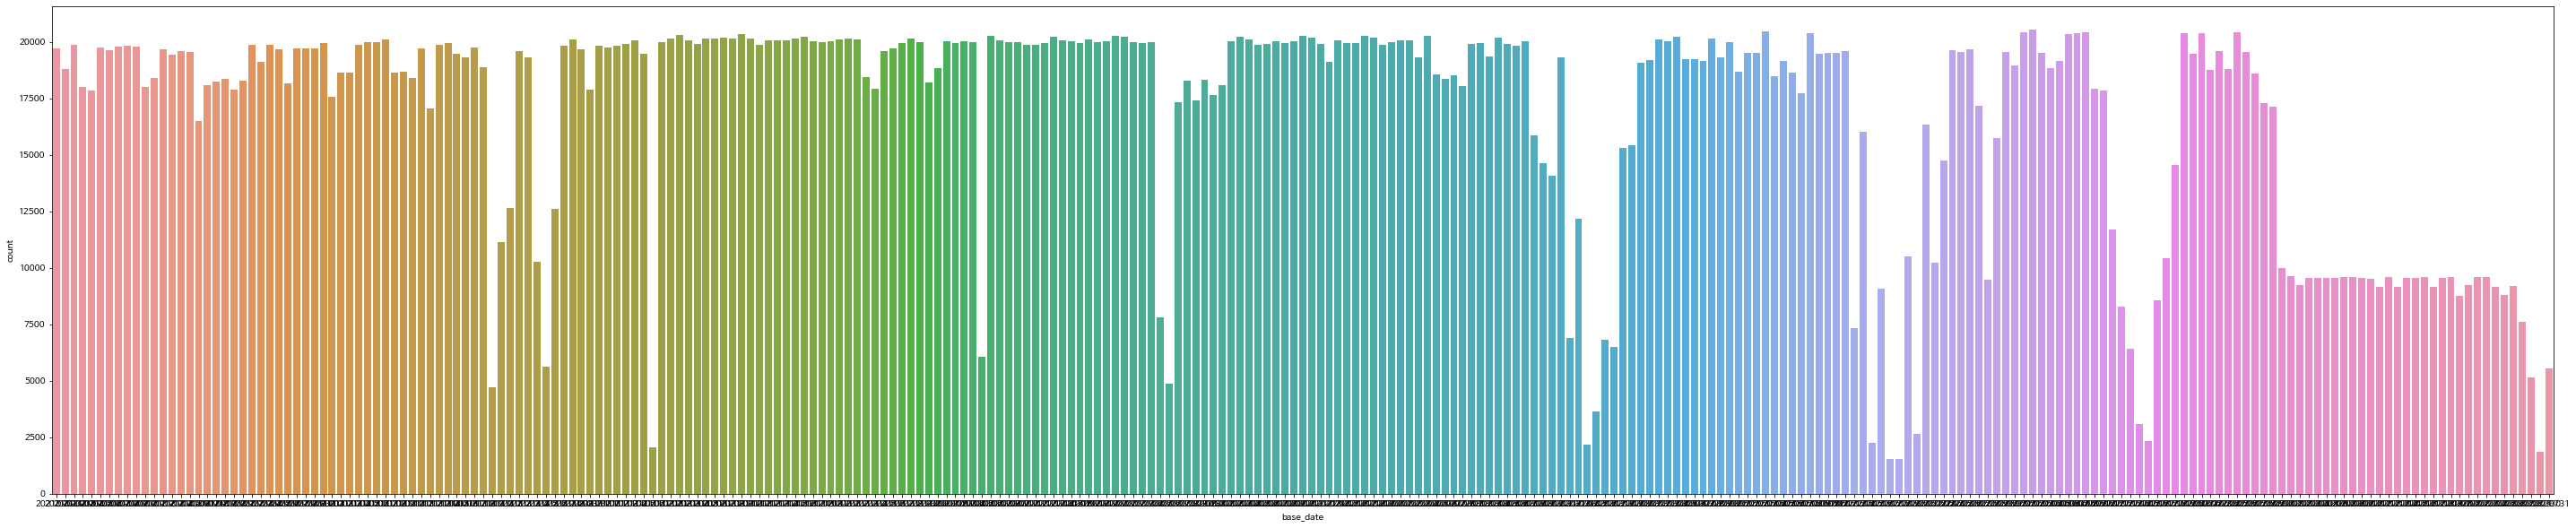

In [ ]:
plt.figure(figsize = (50,10))
sns.countplot(train['base_date'])

### 요일 (day_of_week)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


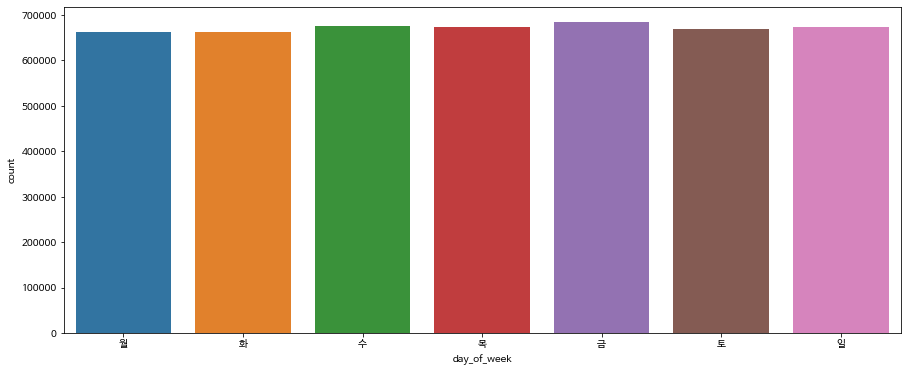

In [ ]:
date_order = ['월','화','수','목','금','토','일']

plt.figure(figsize = (15,6))
sns.countplot(train['day_of_week'],  order=date_order)

### 시간대 (base_hour)

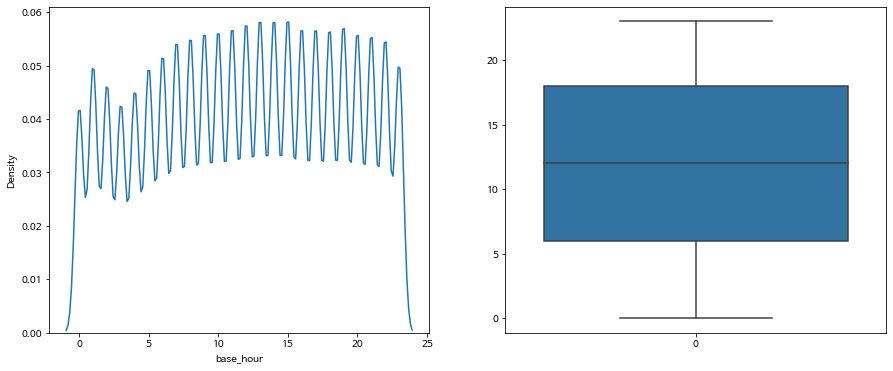

In [ ]:
show_plt(train, 'base_hour')

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


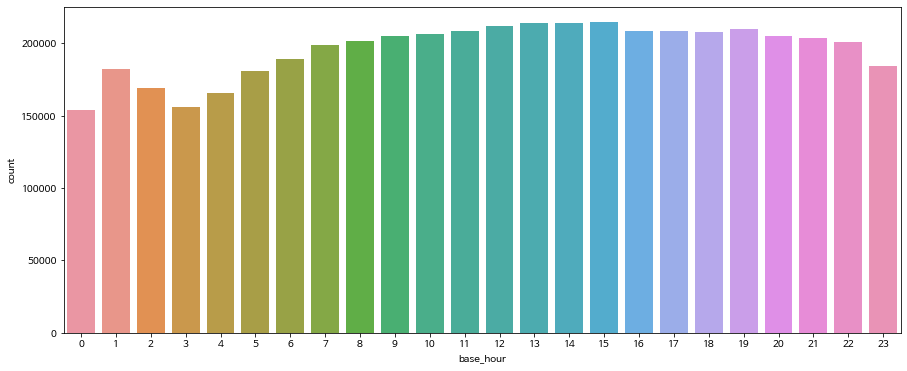

In [ ]:
plt.figure(figsize = (15,6))
sns.countplot(train['base_hour'])

### 차로수(lane_count)

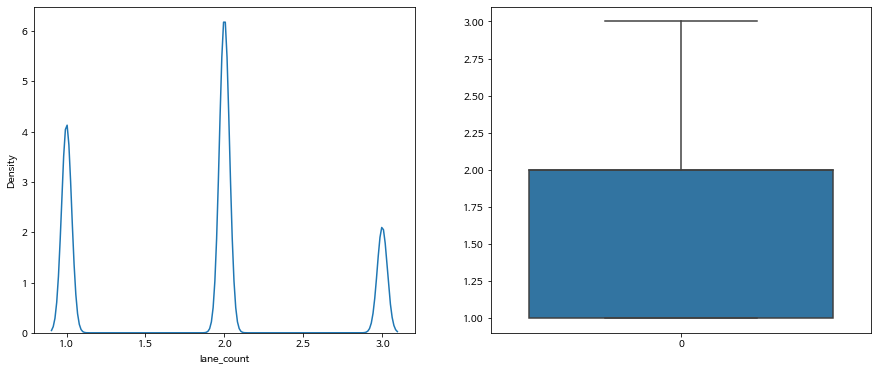

In [ ]:
show_plt(train, 'lane_count')

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


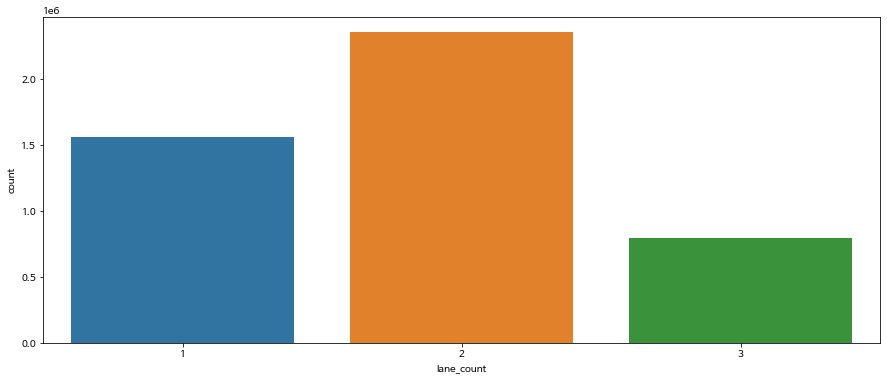

In [ ]:
plt.figure(figsize = (15,6))
sns.countplot(train['lane_count'])

### 도로등급(road_rating)

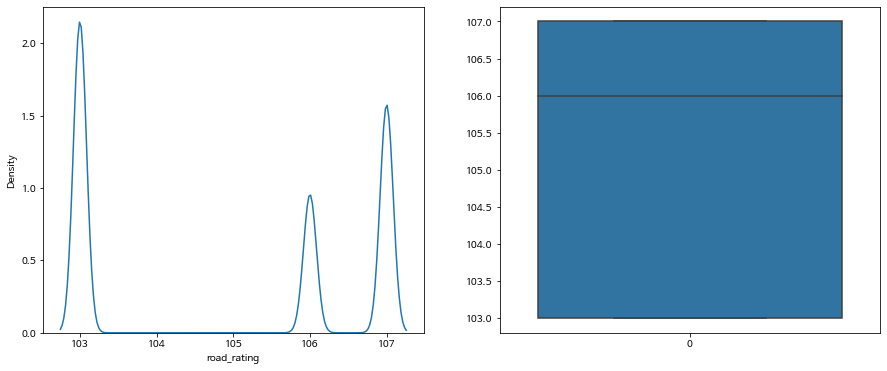

In [ ]:
show_plt(train, 'road_rating')

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


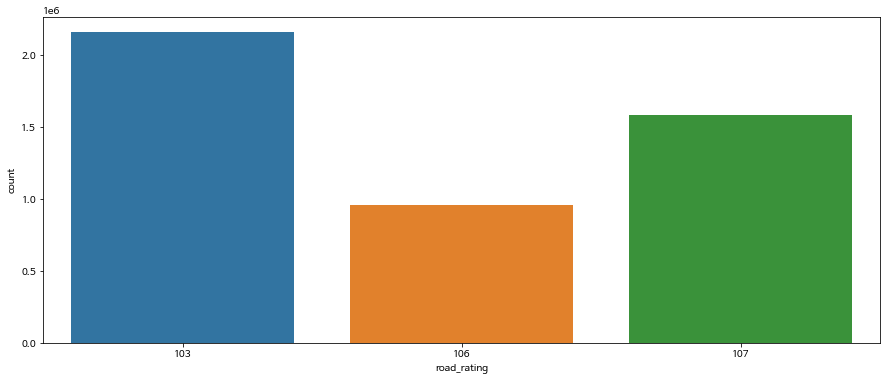

In [ ]:
plt.figure(figsize = (15,6))
sns.countplot(train['road_rating'])

### 중용구간 여부(multi_linked)

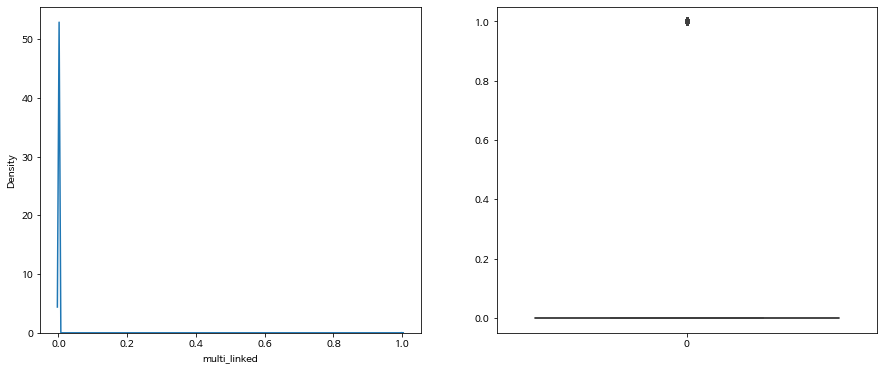

In [ ]:
show_plt(train, 'multi_linked')

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


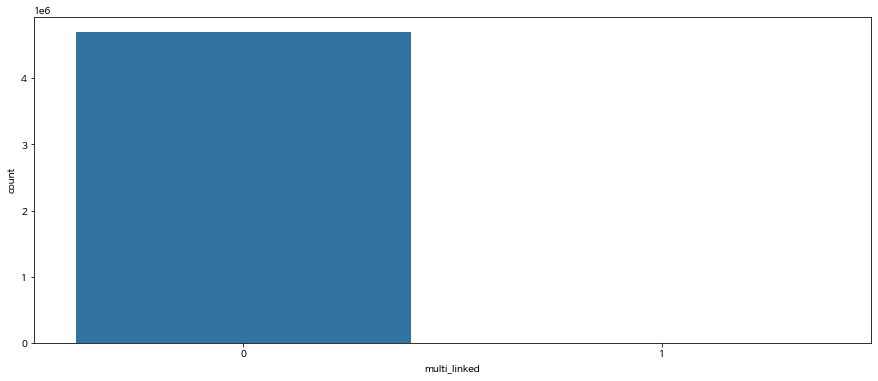

In [ ]:
plt.figure(figsize = (15,6))
sns.countplot(train['multi_linked'])

### 연결로 코드(connect_code)

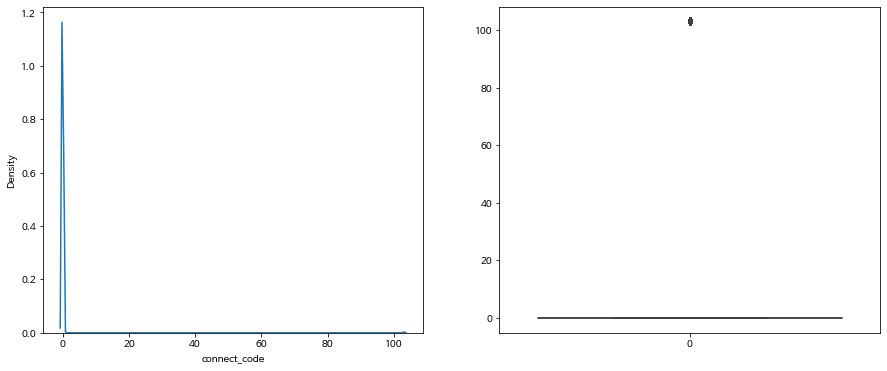

In [ ]:
show_plt(train, 'connect_code')

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


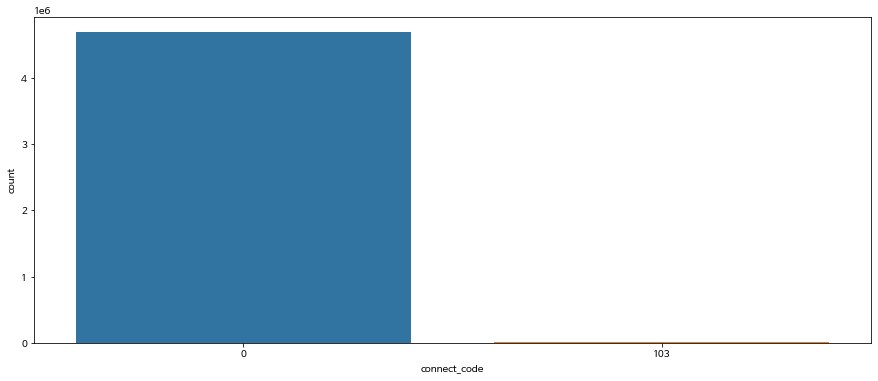

In [ ]:
plt.figure(figsize = (15,6))
sns.countplot(train['connect_code'])

### 최고속도제한(maximum_speed_limit)

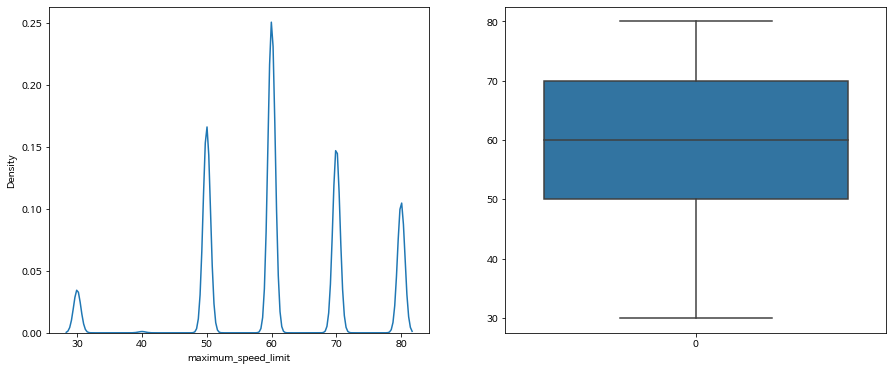

In [ ]:
show_plt(train, 'maximum_speed_limit')

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


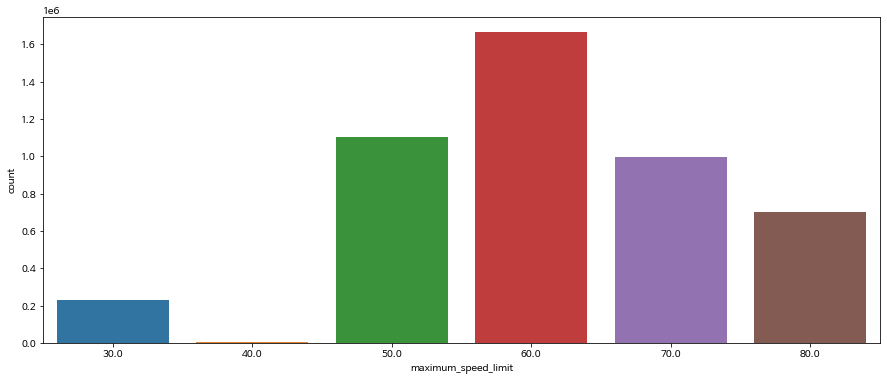

In [ ]:
plt.figure(figsize = (15,6))
sns.countplot(train['maximum_speed_limit'])

### 통과제한하중(weight_restricted)

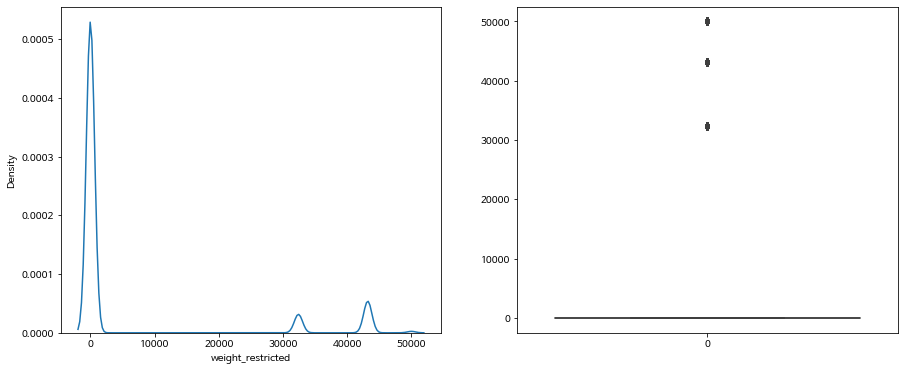

In [ ]:
show_plt(train, 'weight_restricted')

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


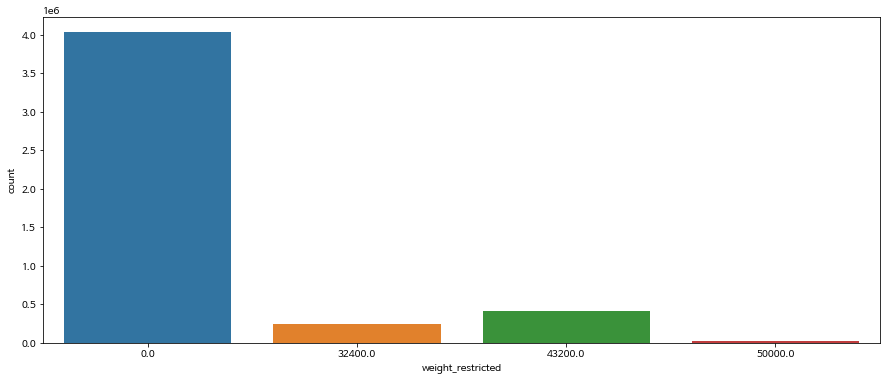

In [ ]:
plt.figure(figsize = (15,6))
sns.countplot(train['weight_restricted'])

### 통과제한높이(height_restricted)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


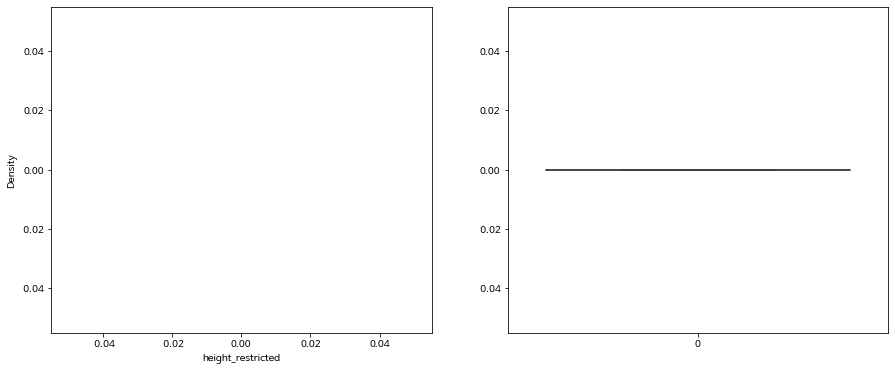

In [ ]:
show_plt(train, 'height_restricted')

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


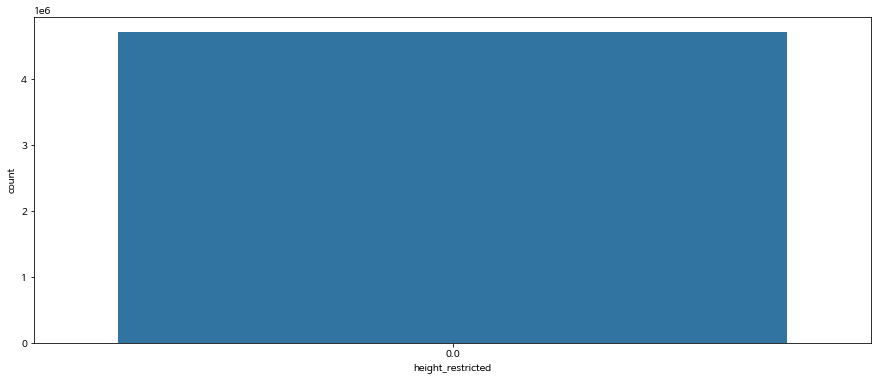

In [ ]:
plt.figure(figsize = (15,6))
sns.countplot(train['height_restricted'])

### 도로유형(road_type)



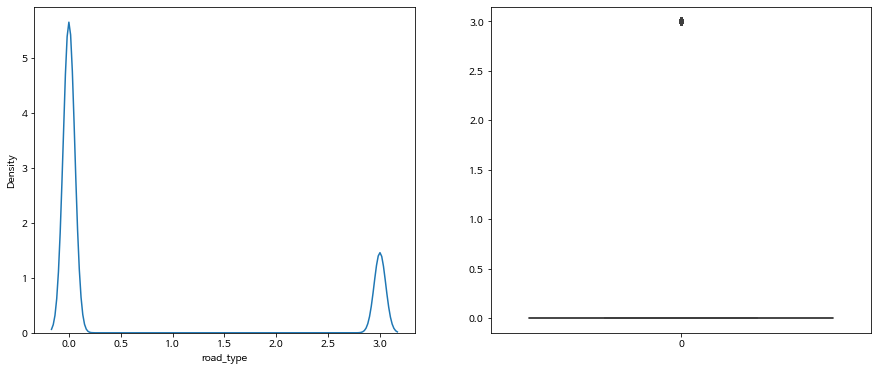

In [ ]:
show_plt(train, 'road_type')

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


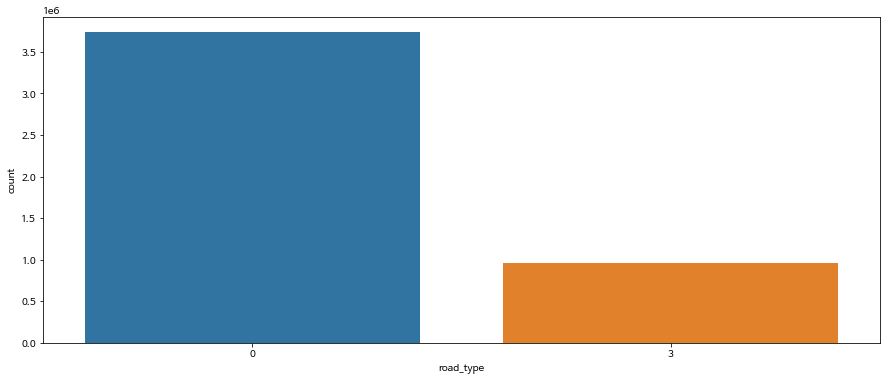

In [ ]:
plt.figure(figsize = (15,6))
sns.countplot(train['road_type'])

### 시작 지점의 위도(start_latitude)

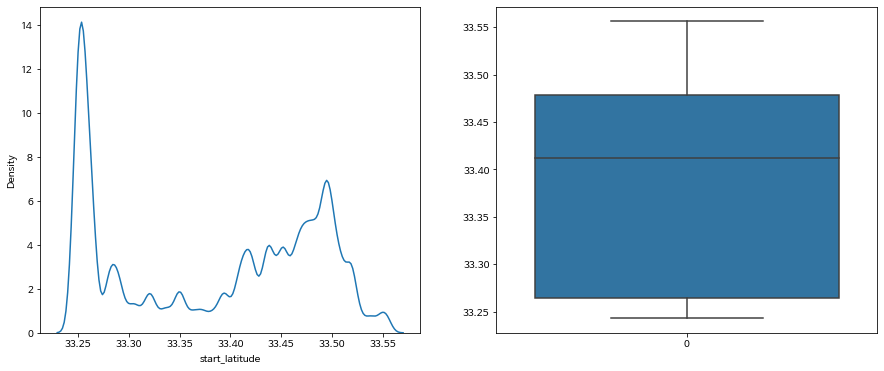

In [ ]:
show_plt(train, 'start_latitude')

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


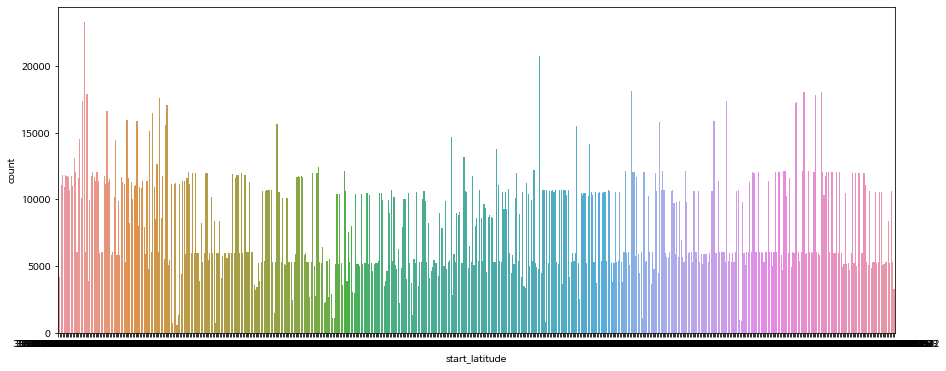

In [ ]:
plt.figure(figsize = (15,6))
sns.countplot(train['start_latitude'])

### 시작 지점의 경도(start_longitude)

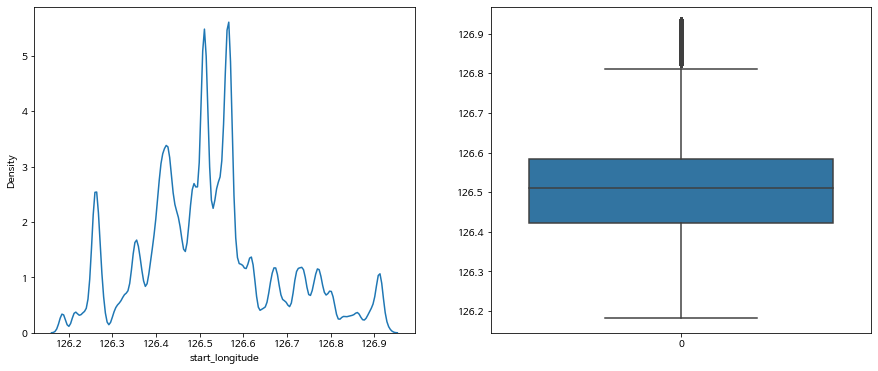

In [ ]:
show_plt(train, 'start_longitude')

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


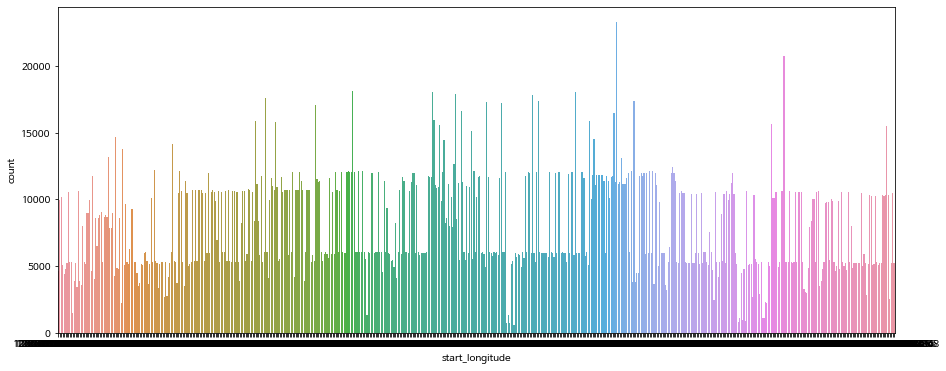

In [ ]:
plt.figure(figsize = (15,6))
sns.countplot(train['start_longitude'])

### 시작 지점의 회전제한(start_turn_restricted)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


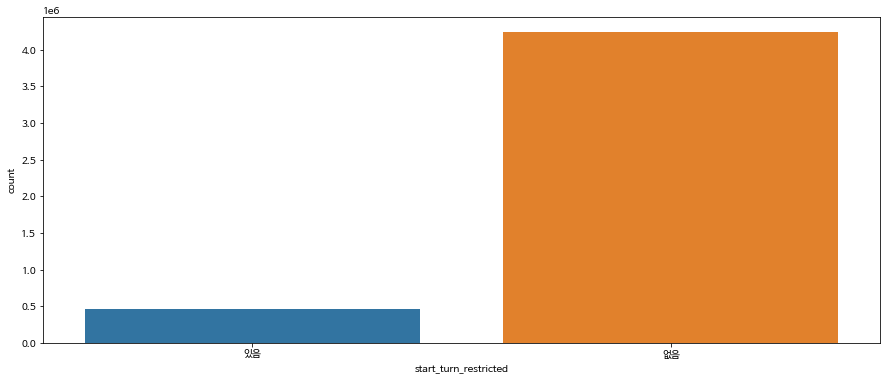

In [ ]:
plt.figure(figsize = (15,6))
sns.countplot(train['start_turn_restricted'])

### 도착지점의 위도(end_latitude)

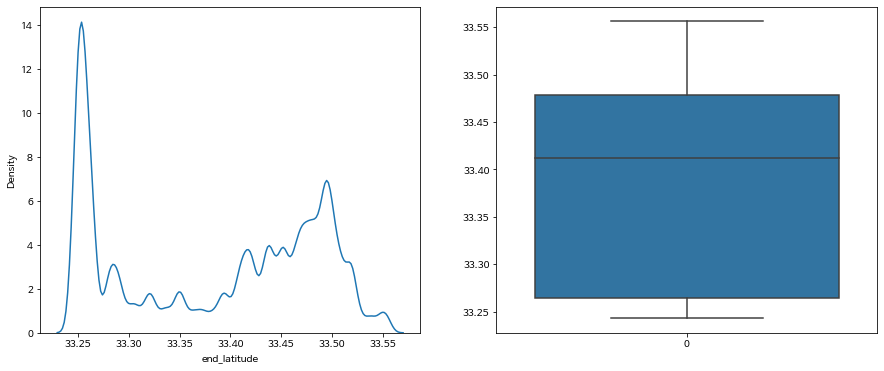

In [ ]:
show_plt(train, 'end_latitude')

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


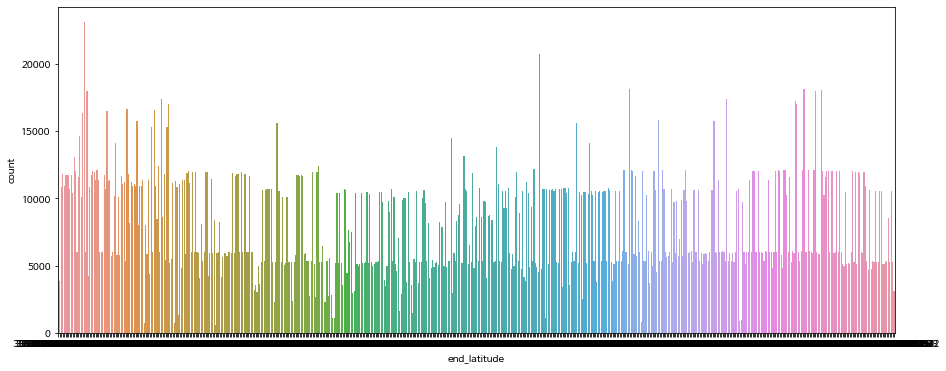

In [ ]:
plt.figure(figsize = (15,6))
sns.countplot(train['end_latitude'])

### 도착지점의 경도(end_longitude)

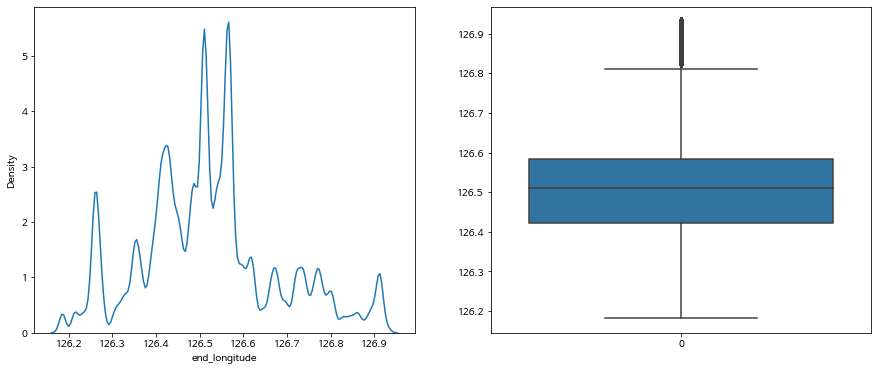

In [ ]:
show_plt(train, 'end_longitude')

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


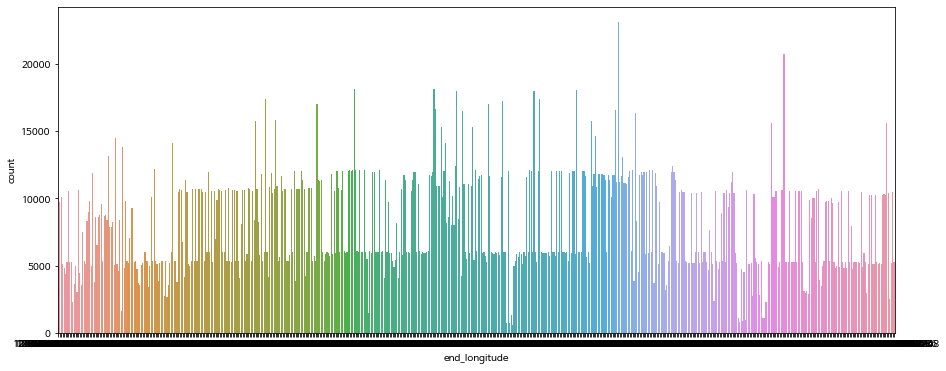

In [ ]:
plt.figure(figsize = (15,6))
sns.countplot(train['end_longitude'])

### 도착지점의 회전제한(end_turn_restricted)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


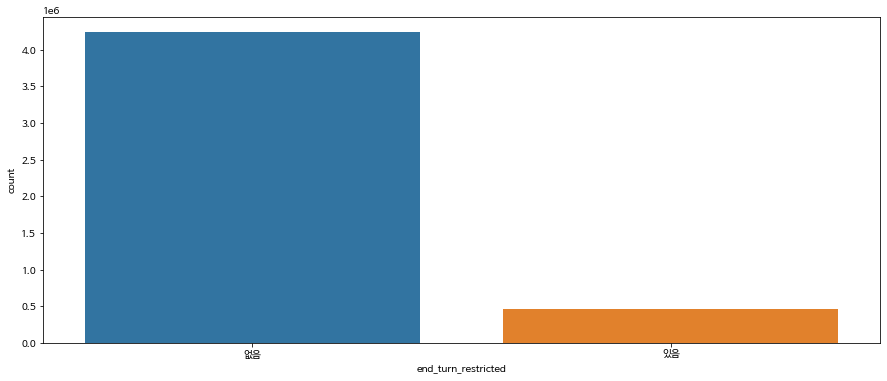

In [ ]:
plt.figure(figsize = (15,6))
sns.countplot(train['end_turn_restricted'])

### 도로명(road_name)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


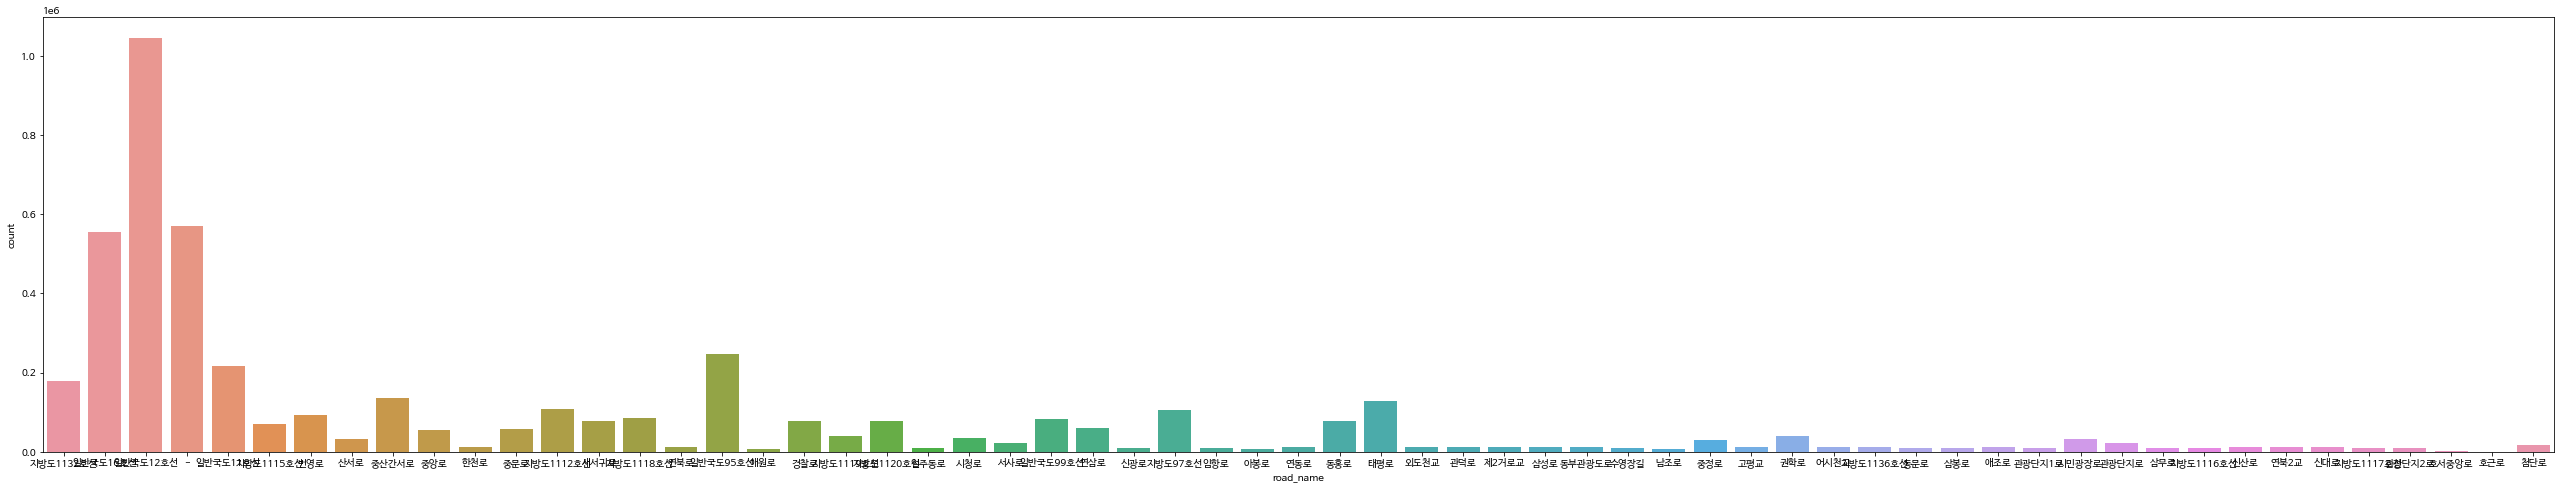

In [ ]:
plt.figure(figsize = (45,8))
sns.countplot(train['road_name'])

### 시작지점명(start_node_name)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


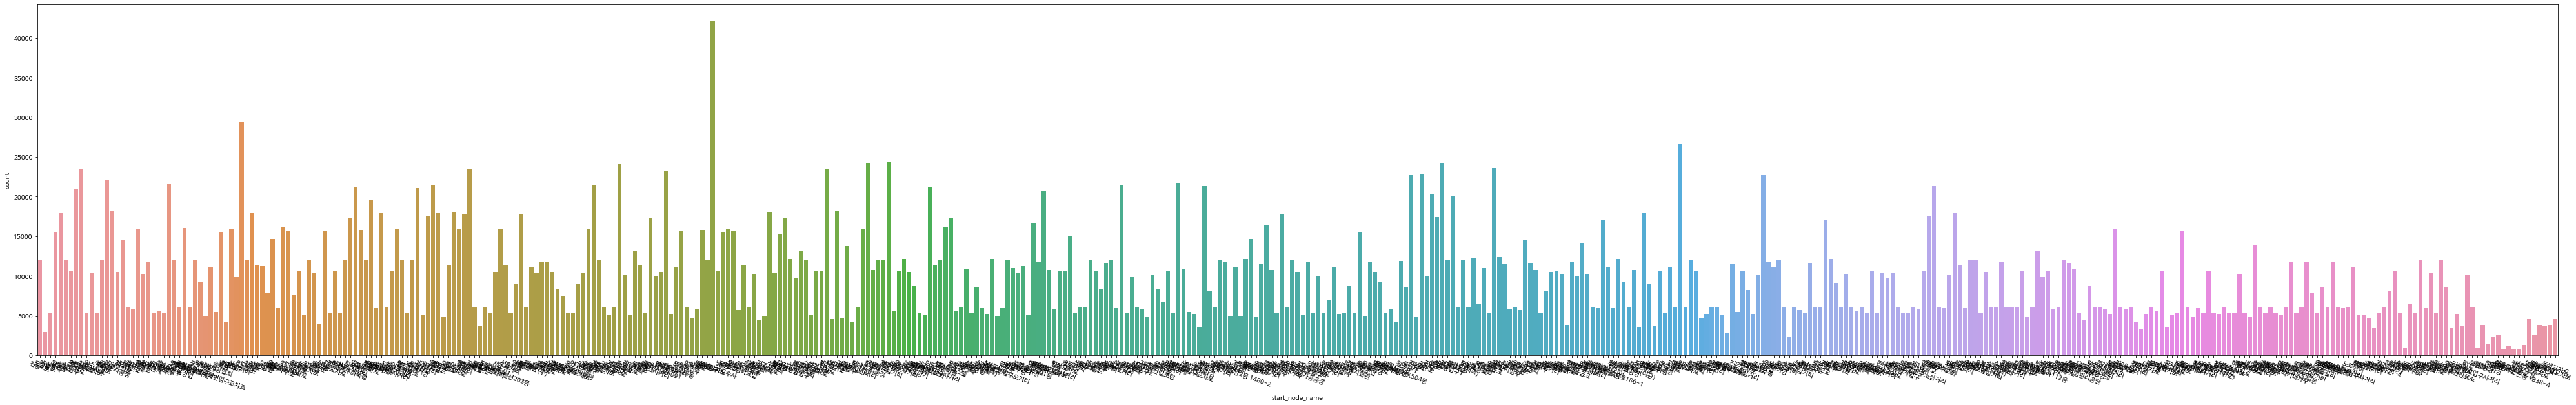

In [ ]:
plt.figure(figsize = (70,10))
plt.xticks(rotation=-20)
sns.countplot(train['start_node_name'])

### 도착지점명(end_node_name)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


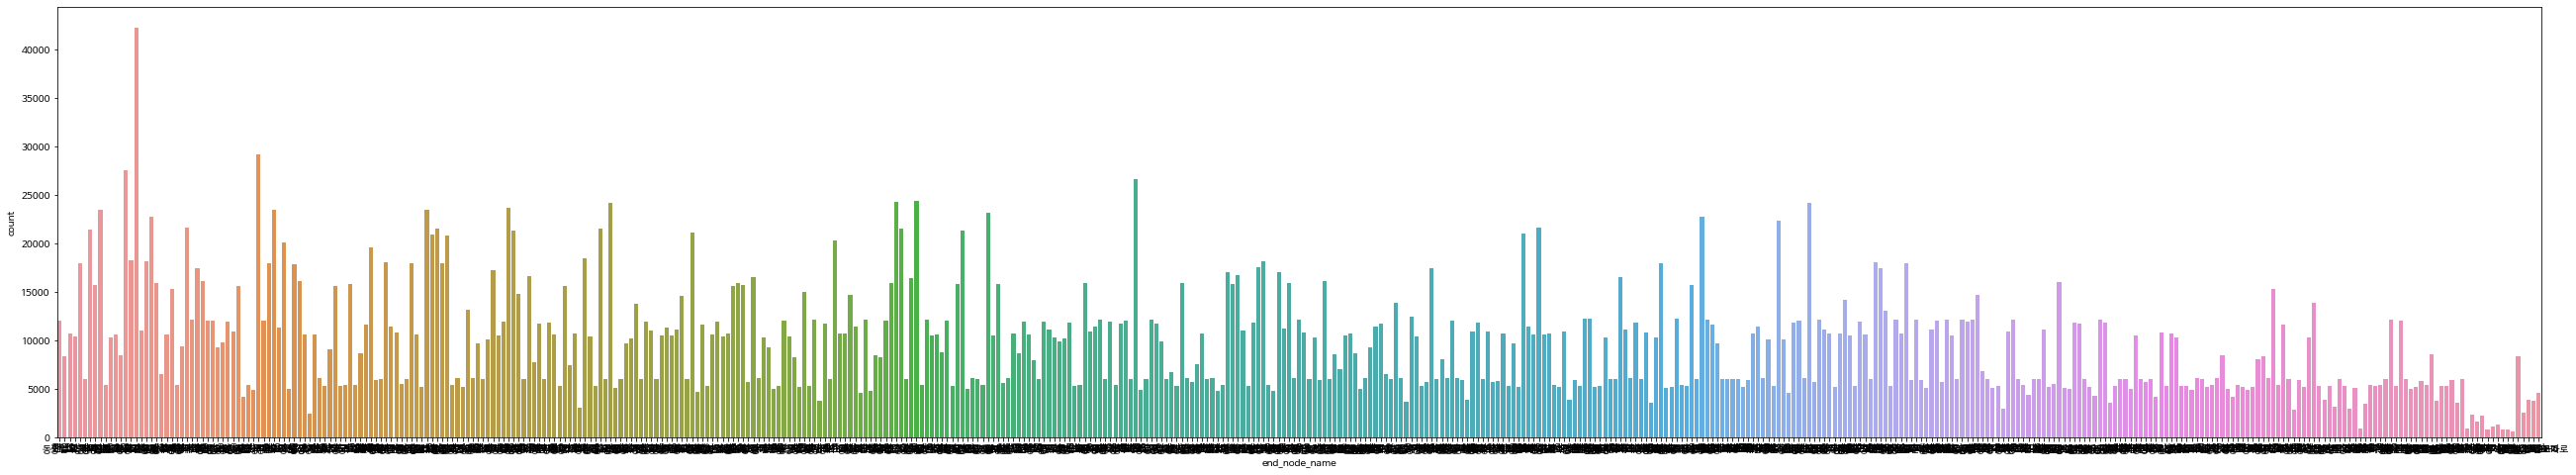

In [ ]:
plt.figure(figsize = (45,8))
sns.countplot(train['end_node_name'])

### 통과제한차량(vehicle_restricted)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


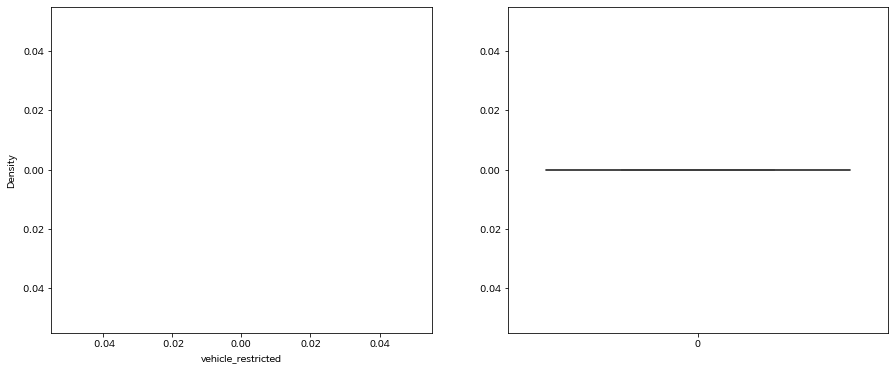

In [ ]:
show_plt(train, 'vehicle_restricted')

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


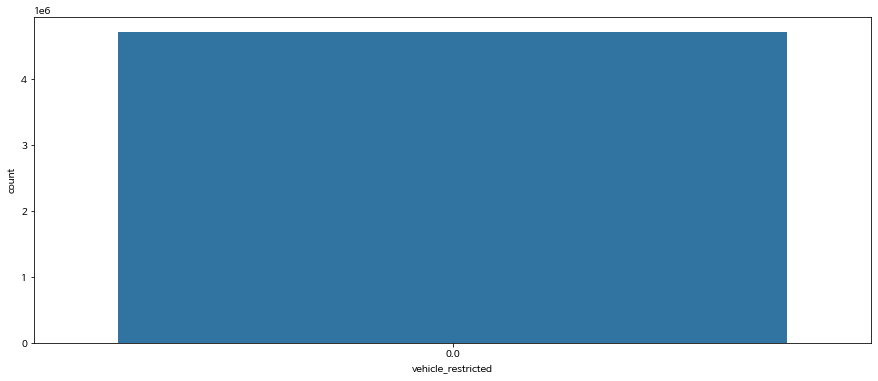

In [ ]:
plt.figure(figsize = (15,6))
sns.countplot(train['vehicle_restricted'])

### 평균속도(target)

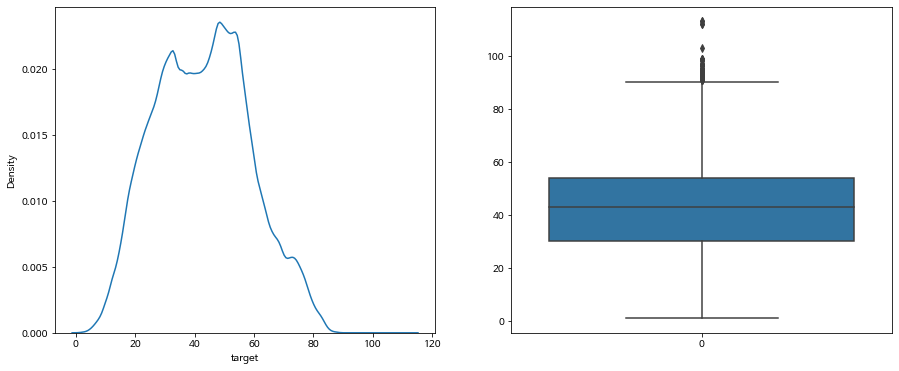

In [ ]:
show_plt(train, 'target')

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


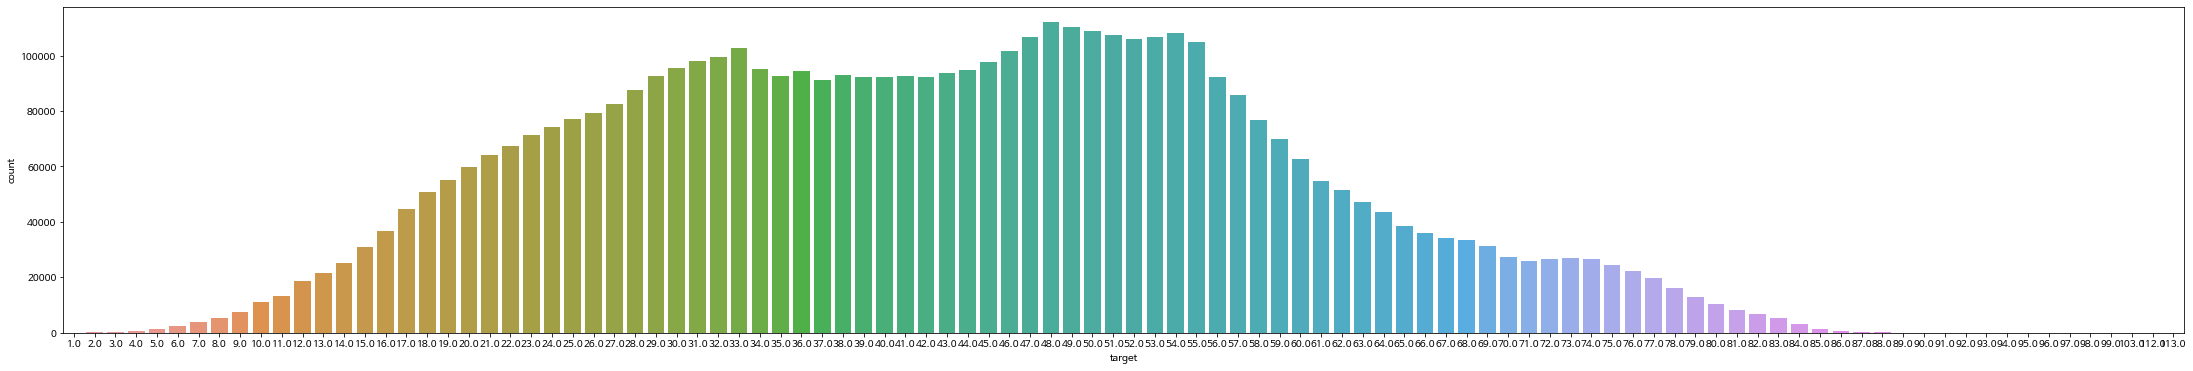

In [ ]:
plt.figure(figsize = (38,6))
sns.countplot(train['target'])

### 월(month)

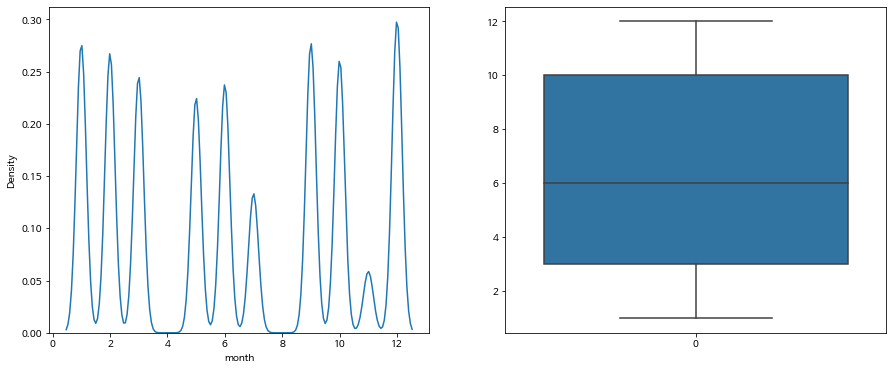

In [ ]:
show_plt(train, 'month')

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


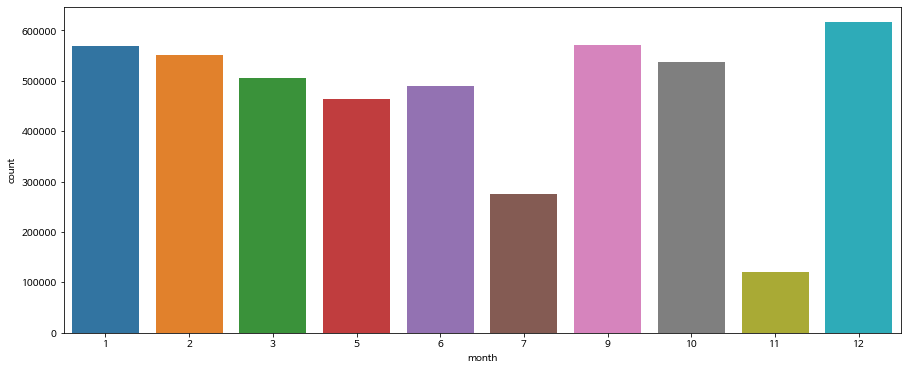

In [ ]:
plt.figure(figsize = (15,6))
sns.countplot(train['month'])

### 주말, 평일(weekend)

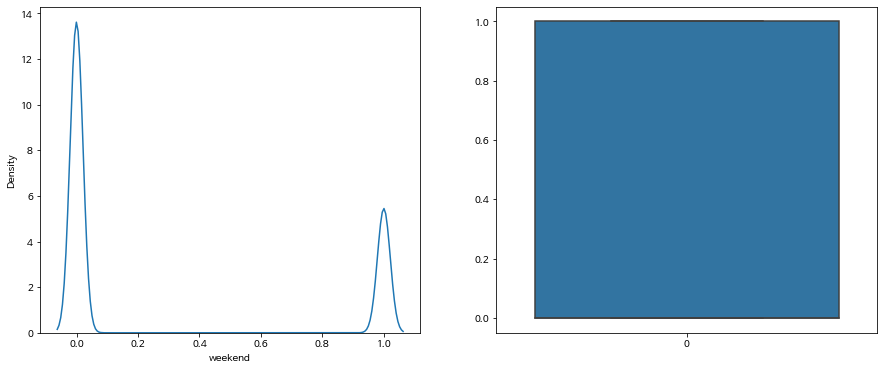

In [ ]:
show_plt(train, 'weekend')

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


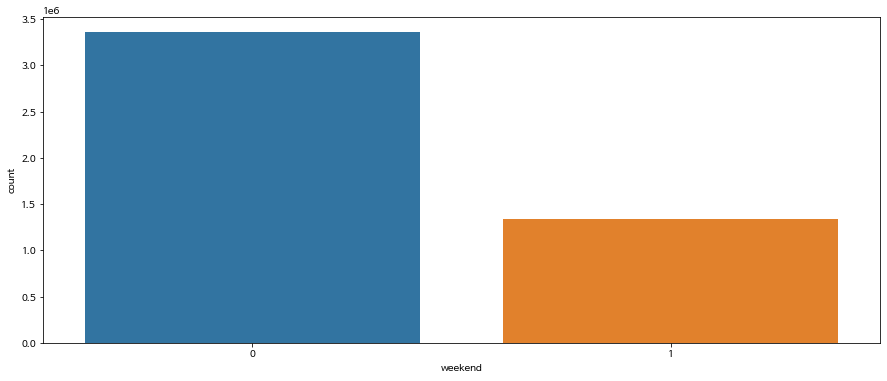

In [ ]:
plt.figure(figsize = (15,6))
sns.countplot(train['weekend'])

### 시간대(hour_label) - 오전, 오후 저녁, 새벽

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


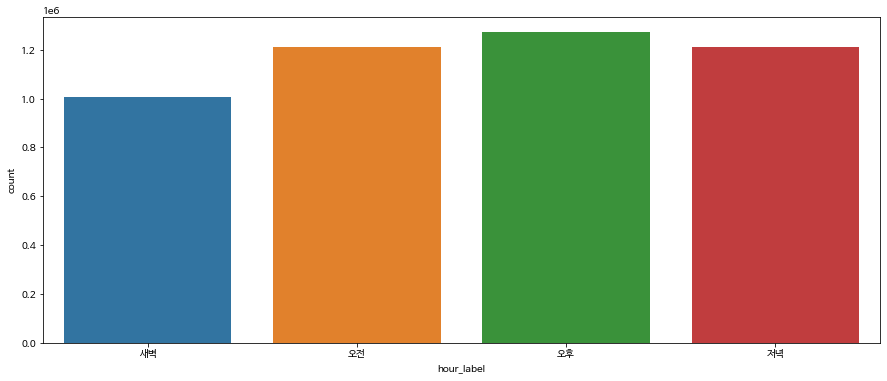

In [ ]:
data_order = ['새벽', '오전', '오후', '저녁']
plt.figure(figsize = (15,6))
sns.countplot(train['hour_label'], order=data_order)

### 공휴일(holiday)

holi = [20210920, 20210921, 20210922, 20211004, 20211011, 20211009, 20211003, 20211225,
        20220101, 20220131, 20220201, 20220202, 20220301, 20220309, 20220501, 20220505,
        20220508, 20220601, 20220606, 20220717]


- 추석, 설날, 성탄절, 국가공휴일, 대체 공휴일 등등

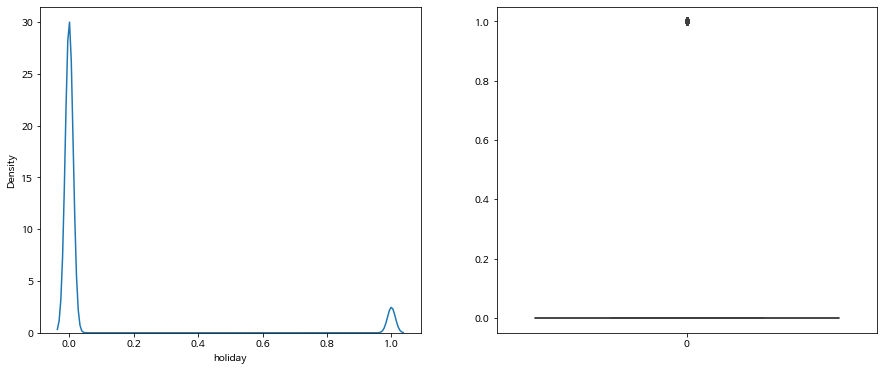

In [ ]:
show_plt(train, 'holiday')

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


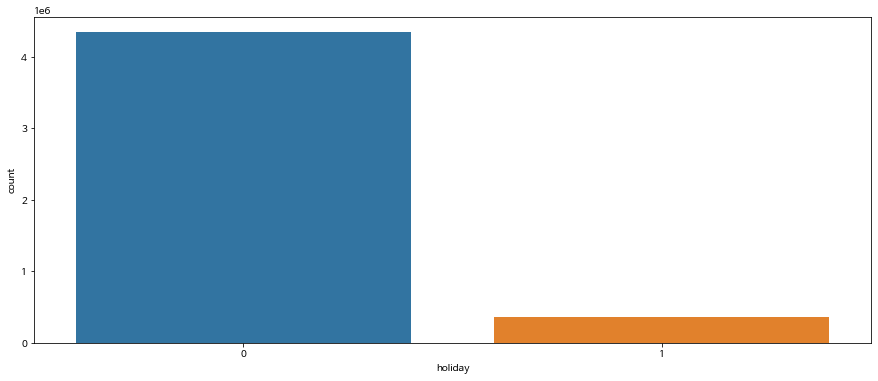

In [ ]:
plt.figure(figsize = (15,6))
sns.countplot(train['holiday'])

### 장마(rain_season)

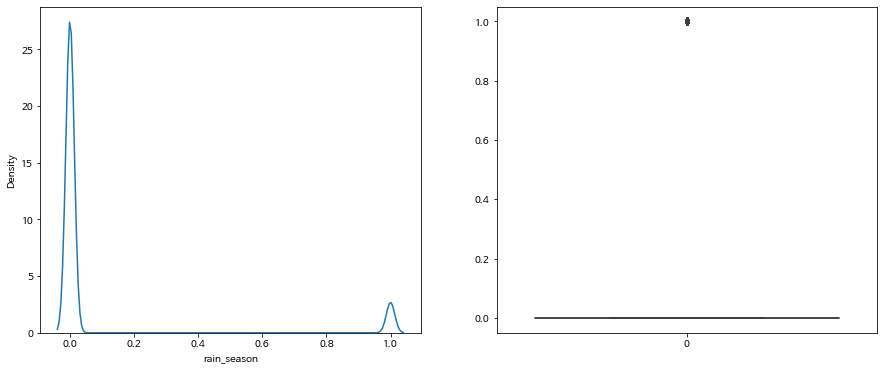

In [ ]:
show_plt(train, 'rain_season')

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


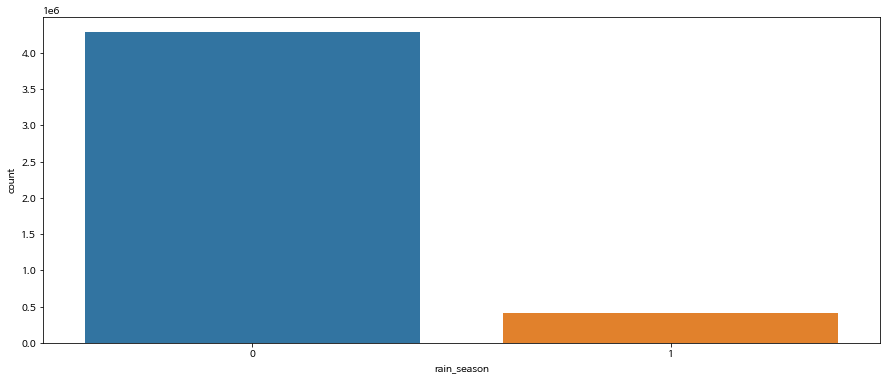

In [ ]:
plt.figure(figsize = (15,6))
sns.countplot(train['rain_season'])

### 계절(season) 

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


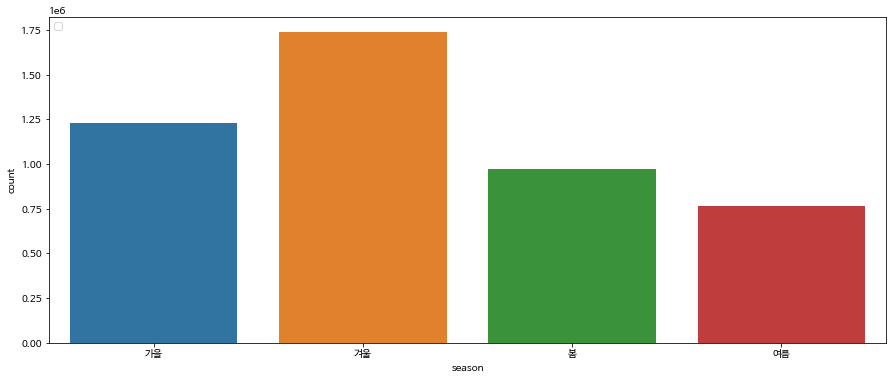

In [ ]:
plt.figure(figsize = (15,6))
plt.legend(loc='upper left')
sns.countplot(train['season'])

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4701217 entries, 430379 to 4680098
Data columns (total 29 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   id                     object 
 1   base_date              int64  
 2   day_of_week            object 
 3   base_hour              int64  
 4   lane_count             int64  
 5   road_rating            int64  
 6   road_name              object 
 7   multi_linked           int64  
 8   connect_code           int64  
 9   maximum_speed_limit    float64
 10  vehicle_restricted     float64
 11  weight_restricted      float64
 12  height_restricted      float64
 13  road_type              int64  
 14  start_node_name        object 
 15  start_latitude         float64
 16  start_longitude        float64
 17  start_turn_restricted  object 
 18  end_node_name          object 
 19  end_latitude           float64
 20  end_longitude          float64
 21  end_turn_restricted    object 
 22  target       

## 상관계수

In [ ]:
tar_corr = train.corr()[abs(train.corr()) > 0.005]
# tar_corr = train.corr()

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


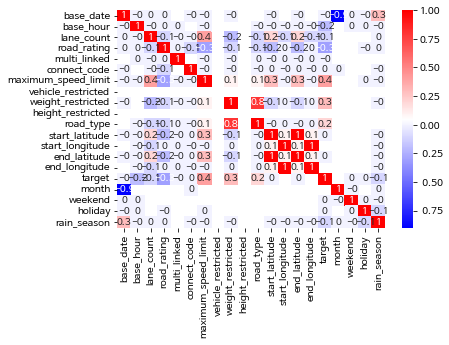

In [ ]:
import matplotlib.pyplot as plt
from matplotlib import rc
import seaborn as sns

%matplotlib inline

sns.heatmap(data = tar_corr.round(1), annot = True, cmap = 'bwr')
plt.show()

In [ ]:
tar_corr.iloc[-3]

base_date              0.009942
base_hour              0.009305
lane_count                  NaN
road_rating                 NaN
multi_linked                NaN
connect_code                NaN
maximum_speed_limit         NaN
vehicle_restricted          NaN
weight_restricted           NaN
height_restricted           NaN
road_type                   NaN
start_latitude              NaN
start_longitude             NaN
end_latitude                NaN
end_longitude               NaN
target                 0.009859
month                 -0.024970
weekend                1.000000
holiday                0.032463
rain_season           -0.006132
Name: weekend, dtype: float64